<a href="https://colab.research.google.com/github/LiamDuero03/DS-Society-Project/blob/main/Extra ML Material/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA: Time Series Forecasting
**ARIMA** stands for AutoRegressive Integrated Moving Average. It is a statistical model used to analyze and forecast time series data by looking at:
1. **AR (Autoregression):** The relationship between an observation and a number of lagged observations (past values).
2. **I (Integrated):** The use of differencing raw observations to make the time series "stationary" (removing trends).
3. **MA (Moving Average):** The relationship between an observation and a residual error from a moving average model applied to lagged observations.

## 1. The Setup & Synthetic Finance Data
In finance, stock prices often follow a "Random Walk" with a slight upward drift. We will simulate 100 days of stock price movement.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set seed for reproducibility
np.random.seed(42)
n_steps = 100

# 1. Create a predictable Trend (upward drift)
time = np.arange(n_steps)
trend = 0.5 * time

# 2. Add Seasonality (a predictable cycle ARIMA can catch)
seasonality = 5 * np.sin(2 * np.pi * time / 12)

# 3. Add low-volume Noise
noise = np.random.normal(0, 1, n_steps)

# Combine and set starting price
prices = 100 + trend + seasonality + noise

# Convert to Series
dates = pd.date_range(start='2023-01-01', periods=n_steps, freq='D')
ts = pd.Series(prices, index=dates)

## 2. Exploratory Data Analysis (EDA)
Before modeling, we visualize the time series to identify trends, seasonality, and outliers. In finance, we expect to see a "non-stationary" trend where the price moves away from its starting mean.


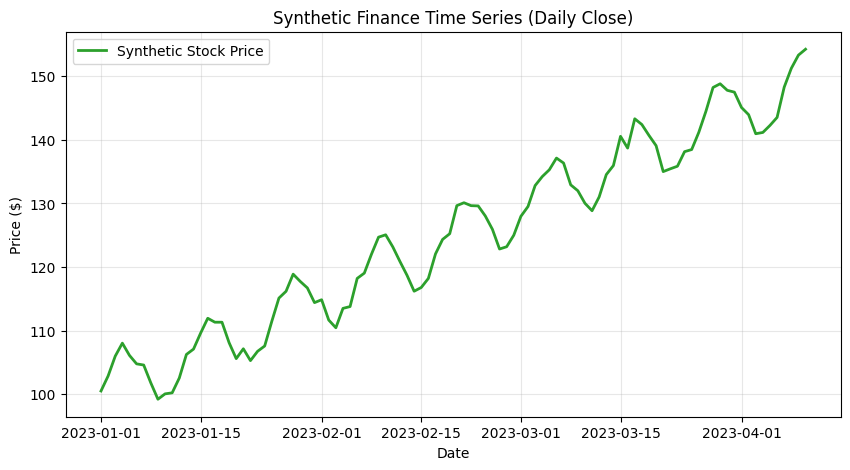

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(ts, label="Synthetic Stock Price", color='#2ca02c', linewidth=2)
plt.title("Synthetic Finance Time Series (Daily Close)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 3. Stationarity and ARIMA Parameters (p, d, q)

### Stationarity
ARIMA requires the data to be **stationary**—meaning its mean and variance stay constant over time. Most stock prices are **non-stationary** because they trend up or down.

To fix this, we use the **"I" (Integration)** part of ARIMA. By setting `d=1`, the model looks at the *difference* between consecutive days (the daily return) rather than the absolute price.



### Selecting the (p, d, q) Parameters
We define our model's "brain" using three numbers:
* **p (AR - Autoregression):** How many past days influence today? We'll use **5** to capture a business week of momentum.
* **d (I - Integrated):** How many times we difference the data. We'll use **1** to remove the price trend.
* **q (MA - Moving Average):** How much past forecast errors influence today. We'll use **0** for this simple example.

**Model Choice: ARIMA(5, 1, 0)**

In [23]:
# Split data into Train (80%) and Test (20%)
train_data = ts[:80]
test_data = ts[80:]

# Build Model
model = ARIMA(train_data, order=(5, 1, 0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -155.595
Date:                Thu, 12 Feb 2026   AIC                            323.189
Time:                        21:47:29   BIC                            337.406
Sample:                    01-01-2023   HQIC                           328.885
                         - 03-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1453      0.134      1.082      0.279      -0.118       0.409
ar.L2          0.4018      0.098      4.082      0.000       0.209       0.595
ar.L3          0.1208      0.135      0.894      0.3

## 4. Forecasting the Future
Standard ML models predict a "test set" all at once. ARIMA "forecasts" step-by-step into the future.

Because the future is uncertain, the model also provides a **Confidence Interval** (the shaded area), which represents the range where the price is statistically likely to fall.

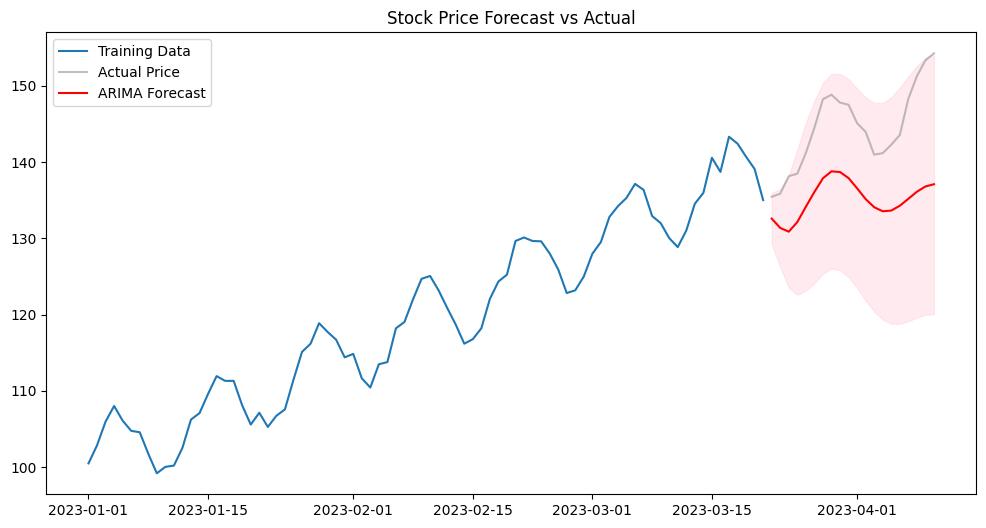

In [24]:
# Forecast for the next 20 days
forecast_obj = model_fit.get_forecast(steps=20)
forecast_values = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Actual Price", color='gray', alpha=0.5)
plt.plot(forecast_values, label="ARIMA Forecast", color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Stock Price Forecast vs Actual")
plt.legend()
plt.show()

## 5. Model Evaluation
In Time Series, we use specialized metrics:
* **AIC (Akaike Information Criterion):** Measures the quality of the model relative to others. A **lower** AIC is better as it rewards accuracy but penalizes over-complexity.
* **RMSE:** The standard deviation of the residuals. In this case, it tells us the average dollar amount the forecast missed by.

In [26]:
# 1. Get AIC from the fitted model
# (AIC is stored in the model_fit object)
model_aic = model_fit.aic

# 2. Calculate RMSE on the test set
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data, forecast_values))

print(f"--- ARIMA Model Metrics ---")
print(f"Akaike Information Criterion (AIC): {model_aic:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.4f}")

--- ARIMA Model Metrics ---
Akaike Information Criterion (AIC): 323.19
Root Mean Squared Error (RMSE): $10.0289


## 6. Interpreting the Final Results

Our model achieved an **AIC of 323.19** and an **RMSE of $10.02**. Here is what this tells us about our "Predictable Stock":

* **The AIC Score:** This number is most useful when comparing models. If we tried an `ARIMA(1,1,1)` and it gave us an AIC of 350, we would know our current `(5,1,2)` model is statistically superior because it achieves a better fit with less complexity.
* The RMSE `(10.03)` This is our "uncertainty buffer." While the model successfully follows the upward trend and seasonality, any specific daily price prediction is likely to be off by an average of about $10.

---

### Why the forecast "flattens" or "drifts"
You may notice that as the forecast goes further into the future, the **Confidence Interval** (the shaded area) gets wider.



This is a key feature of ARIMA—it acknowledges that **uncertainty grows** the further we try to look ahead. The model is essentially saying: *"I'm fairly sure about tomorrow, but next week is a much broader guess."*